In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None, 
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):
        
        color = next(color_cycle)
        
        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    

def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
    
    
def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):    
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values
    
    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    
    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold
    
    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]
    
    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}
    
    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)
    
    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])
        
        angles.append(overall_angle)  
        distances.append(distance_traveled)
        
        
    
    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)
        
    return df, saccade_events_df


In [3]:
# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b
    
    return block_collection, block_dict

# Example usage:
animals = ['PV_126', 'PV_62']
block_lists = [[7], [23]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals, 
    block_lists=block_lists, 
    experiment_path=experiment_path, 
    bad_blocks=bad_blocks
)

instantiated block number 007 at Path: Z:\Nimrod\experiments\PV_126\2024_07_18\block_007, new OE version
Found the sample rate for block 007 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 007
got it!
instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!


In [4]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    # calibrate pupil diameter:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 007 has a parsed events file, reading...
getting eye brigtness values for block 007...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 023 has a parsed events file, reading...
getting eye brigtness values for block 023...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder


In [5]:
# camera jitter stable epochs collection:
stop_indices_l = []
stop_indices_r = []
for block in tqdm.tqdm(block_collection):
    block.get_jitter_reports(export=False,overwrite=False,remove_led_blinks=False)
    rdf = pd.DataFrame.from_dict(block.re_jitter_dict)
    ldf = pd.DataFrame.from_dict(block.le_jitter_dict)
    bokeh_plotter([rdf.top_correlation_dist], label_list=['drift_distance'])
    stop_ind_r = input('ind to stop?')
    bokeh_plotter([ldf.top_correlation_dist], label_list=['drift_distance'])
    stop_ind_l = input('ind to stop?')
    stop_indices_l.append(stop_ind_l)
    stop_indices_r.append(stop_ind_r)
    

  0%|          | 0/2 [00:00<?, ?it/s]

jitter report loaded from analysis folder
Got the jitter report - check out re/le_jitter_dict attributes


 50%|█████     | 1/2 [00:23<00:23, 23.12s/it]

jitter report loaded from analysis folder
Got the jitter report - check out re/le_jitter_dict attributes


100%|██████████| 2/2 [00:47<00:00, 23.80s/it]


In [6]:
stop_arr_l = np.array(stop_indices_l).astype(int)
stop_arr_r = np.array(stop_indices_r).astype(int)

distances_collection = []
for i, block in enumerate(block_collection):
    # define jitter dicts
    jitter_dict_l = block.le_jitter_dict
    jitter_dict_r = block.re_jitter_dict
    
    # compute euclidean jitter magnitude
    xl = np.array(jitter_dict_l['x_displacement'])
    yl = np.array(jitter_dict_l['y_displacement'])
    l_distances = (np.sqrt(xl**2+yl**2)*block.L_pix_size*1000)[:stop_arr_l[i]]
    
    
    # compute euclidean jitter magnitude
    xr = np.array(jitter_dict_r['x_displacement'])
    yr = np.array(jitter_dict_r['y_displacement'])
    r_distances = (np.sqrt(xr**2+yr**2)*block.R_pix_size*1000)[:stop_arr_r[i]]
    
    distances_collection.append(np.concatenate([l_distances, r_distances]))

distances = np.concatenate(distances_collection)

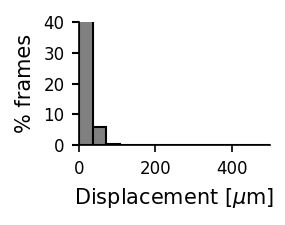

In [8]:
# export the dataset required for this plot:
export=False
if export:
    # Create export directory
    t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
    export_dir = pathlib.Path(fr'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking') / f"{t}_jitter_histogram_with_data"
    export_dir.mkdir(parents=True, exist_ok=True)
    # Save distances as a pickle file
    distances_file = export_dir / "distances.pkl"
    with open(distances_file, "wb") as f:
        pickle.dump(distances, f)

plt.style.use('default')

# Create cumulative distribution plot
#sns.set(style="whitegrid")
fig, axs = plt.subplots(1, figsize=(2, 1.6), dpi=150)

# Plot the histogram
hist, bins = np.histogram(distances, bins=np.linspace(0, 500, 15))
percentage = (hist / len(distances)) * 100

# Use 'gray' for bin fill and 'black' for edges
axs.bar(bins[:-1], percentage, width=np.diff(bins), color='gray', edgecolor='black', align='edge')

# Print bins for debugging
# print(f"Bins: {bins}")

# Set title and labels for the histogram
#title = f'Image Displacement'
#axs.set_title(title, fontsize=10)
axs.set_xlabel('Displacement [$\mu$m]', fontsize=10)
axs.set_ylabel('% frames', fontsize=10)

# Adjust tick label sizes
axs.tick_params(axis='both', which='major', labelsize=8)
axs.tick_params(axis='y', which='both', length=3, color='black')  
axs.set_yticks([0,10,20,30,40])
axs.tick_params(axis='y', which='major', length=3, width=1, color='black')
# Set white background and black text
axs.set_facecolor('white')
axs.title.set_color('black')
axs.xaxis.label.set_color('black')
axs.yaxis.label.set_color('black')
axs.tick_params(colors='black')
axs.grid(False)
axs.spines['top'].set_visible(False)  # Remove the top spine
axs.spines['right'].set_visible(False)  # Remove the right spine
axs.spines['left'].set_color('black')
axs.spines['bottom'].set_color('black')
axs.tick_params(axis='y', which='both', length=3.5, color='black')  
axs.tick_params(axis='x', which='both', length=3.5)
# Set x-axis and y-axis limits
axs.set_xlim(0, 500)
axs.set_ylim(0, 40)
if export:
    plt.savefig(export_dir / f'{t} jitter_hist.pdf', format='pdf')
plt.tight_layout()

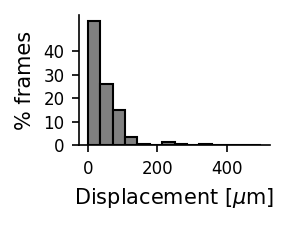

Plot recreated from data in: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\2024_12_15_09_49_jitter_histogram_with_data


In [11]:
import os
import pathlib
import pickle
import numpy as np
import matplotlib.pyplot as plt

def read_and_plot_jitter_histogram(export_base_path):
    """
    Reads distances from a pickle file and recreates the jitter histogram plot.

    Parameters:
    export_base_path (str or pathlib.Path): Base path where the histogram data folder is stored.
    """
    # Find the most recent jitter histogram folder
    export_base_path = pathlib.Path(export_base_path)
    subfolders = sorted(export_base_path.glob("*_jitter_histogram_with_data"), reverse=True)
    
    if not subfolders:
        print("No exported data found!")
        return
    
    # Load the most recent distances file
    latest_folder = subfolders[0]
    distances_file = latest_folder / "distances.pkl"

    if not distances_file.exists():
        print(f"Pickle file not found in {latest_folder}")
        return

    # Load the data
    with open(distances_file, "rb") as f:
        distances = pickle.load(f)
    
    # Create the plot
    fig, axs = plt.subplots(1, figsize=(2, 1.6), dpi=150)
    hist, bins = np.histogram(distances, bins=np.linspace(0, 500, 15))
    percentage = (hist / len(distances)) * 100

    # Plot the histogram
    axs.bar(bins[:-1], percentage, width=np.diff(bins), color='gray', edgecolor='black', align='edge')
    axs.set_xlabel('Displacement [$\mu$m]', fontsize=10)
    axs.set_ylabel('% frames', fontsize=10)
    axs.tick_params(axis='both', which='major', labelsize=8)
    axs.set_yticks([0, 10, 20, 30, 40])
    axs.grid(False)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['left'].set_color('black')
    axs.spines['bottom'].set_color('black')

    plt.tight_layout()
    plt.show()

    print(f"Plot recreated from data in: {latest_folder}")
    
export_base_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking')
read_and_plot_jitter_histogram(export_base_path)